In [38]:
# Library Imports 
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
importlib.reload(mf)

<module 'my_functions' from '/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/sample_coupling_analysis/my_functions.py'>

In [84]:

def plot_spectrum_for_bfield(target_bfield, magnetic_fields, aligned_frequencies, s21_magnitudes, margin=1):
    """
    Plots the S21 spectrum for magnetic field values within a given margin of a target B field.
    
    Parameters:
        target_bfield (float): Target magnetic field value in mT.
        magnetic_fields (numpy array): 1D array of magnetic field values corresponding to spectra.
        aligned_frequencies (numpy array): 1D array of frequency values.
        s21_magnitudes (numpy array): 2D array of S21 values (shape: [num_spectra, num_frequencies]).
        margin (float, optional): Margin around the target B field for selection (default is 1 mT).
    """
    # Find indices of spectra corresponding to the target B field within margin
    matching_indices = np.where(np.isclose(magnetic_fields, target_bfield, atol=margin))[0]

    print(matching_indices)
    if len(matching_indices) == 0:
        print(f"No spectra found within ±{margin} mT of {target_bfield} mT.")
        return
    
    # Plot each matching spectrum
    plt.figure(figsize=(8, 6))
    for idx in matching_indices:
        plt.plot(aligned_frequencies, s21_magnitudes[idx], label=f"B = {magnetic_fields[idx]:.2f} mT")
    
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("S21 Magnitude (dB)")
    plt.title(f"S21 Spectra for B-field ~ {target_bfield} mT")
    plt.legend()
    plt.grid()
    plt.show()

def plot_individual_spectrum(file_path):
    """
    Plots the S21 spectrum for a specified file.
    
    Parameters:
        file_path (str): Path to the VNA data file.
    """
    # Load data
    data = mf.read_VNA_data_magnets(file_path)
    
    # Extract frequency and S21 magnitude
    frequencies = data["Frequency (GHz)"].values
    s21_magnitude = data["S21 (dB)"].values
    magnetic_field = data["Magnetic Field (T)"].values * 1e3  # Convert to mT
    
    # Extract S21 features
    # features_2 = mf.extract_s21_features(frequencies, s21_magnitude)
    # loaded_q = features_2.get("Q_tot")
    # resonant_freq = features_2.get("f_res")
    # s21_max = features_2.get("S21_peak")
    
    # Plot spectrum
    plt.figure(figsize=(8, 6))
    plt.plot(frequencies, s21_magnitude, label=f"B = {magnetic_field[0]:.2f} mT")
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("S21 Magnitude (dB)")
    #plt.title(f"S21 Spectrum for {file_path}")
    plt.xlim([3.923-0.01,3.923+0.01])
    plt.ylim([-80,-50])
    plt.legend()
    plt.grid()
    plt.show()

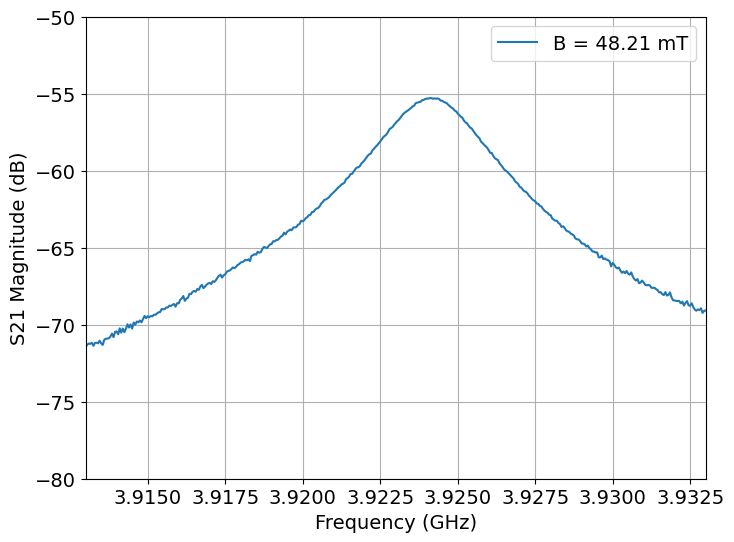

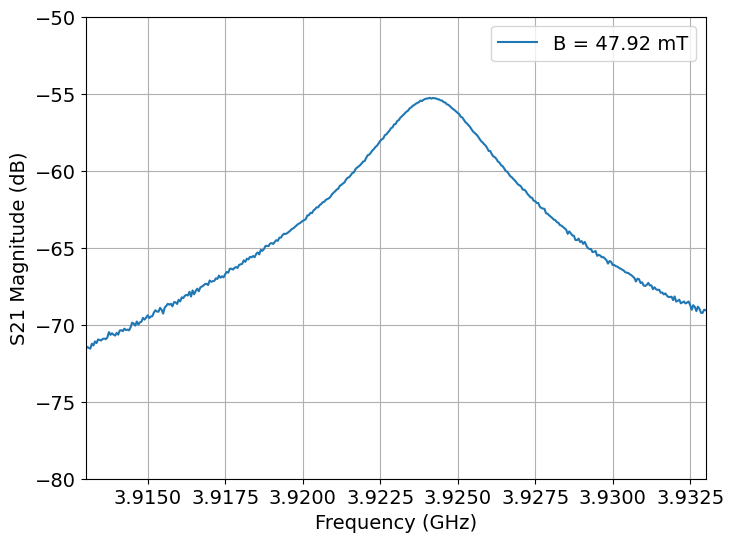

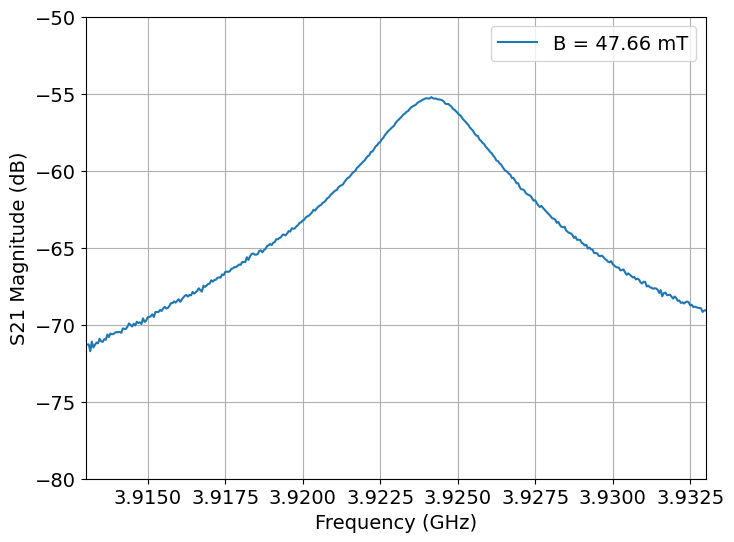

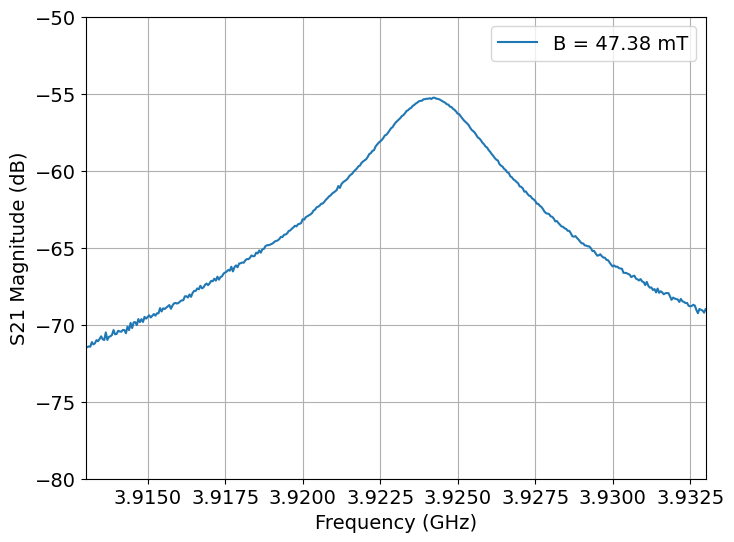

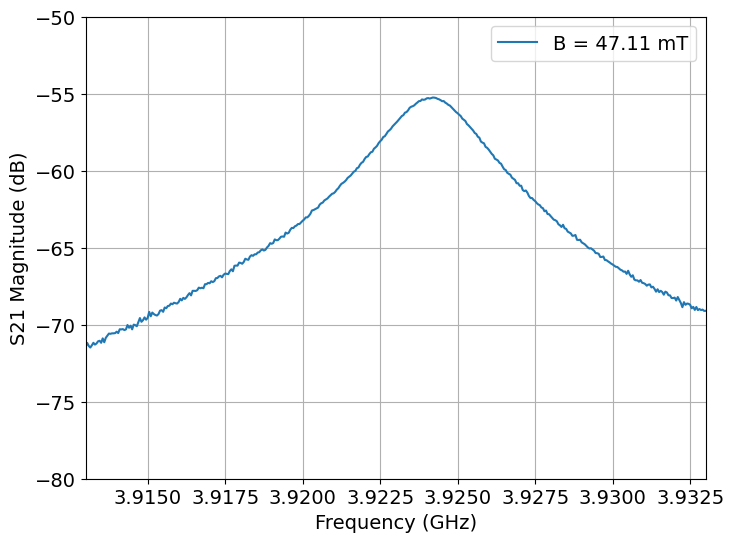

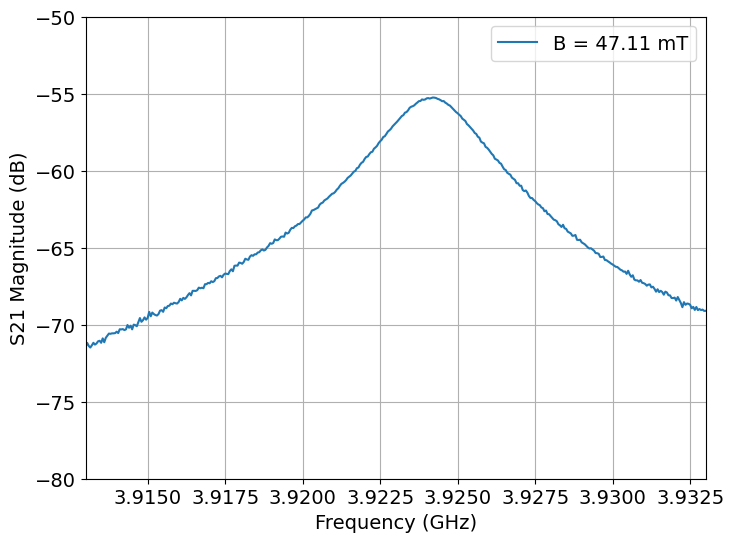

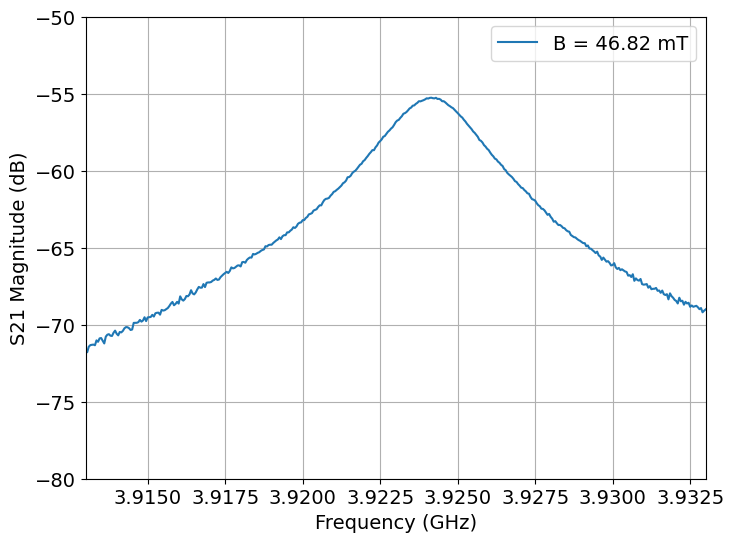

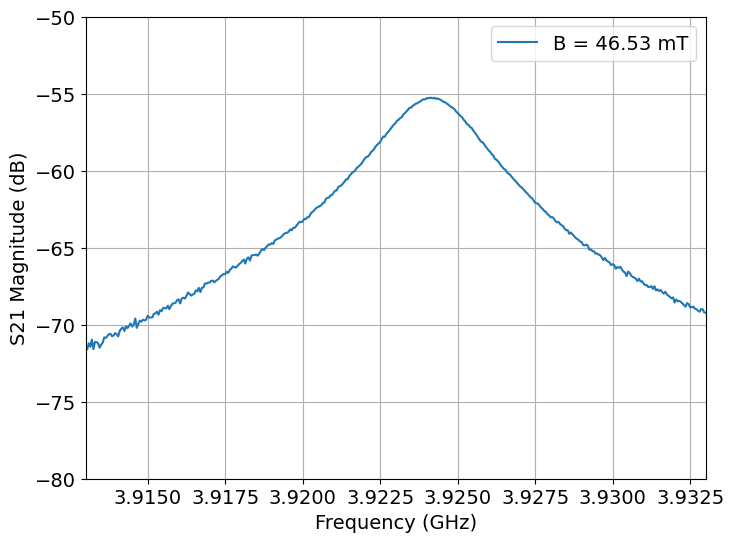

In [89]:
"""
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-39-38
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-40-11
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-40-44
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-41-18
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-41-52
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-41-52
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-42-25
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-42-59
data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-43-32
"""
file_path = "data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-39-38"
plot_individual_spectrum(file_path)
file_path = "data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-40-11"
plot_individual_spectrum(file_path)
file_path = "data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-40-44"
plot_individual_spectrum(file_path)
file_path = "data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-41-18"
plot_individual_spectrum(file_path)
file_path = "data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-41-52"
plot_individual_spectrum(file_path)
plot_individual_spectrum(file_path)
file_path = "data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-42-25"
plot_individual_spectrum(file_path)
file_path = "data_vna/data_03_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-03_22-42-59"
plot_individual_spectrum(file_path)


(330, 4001)
(330,)


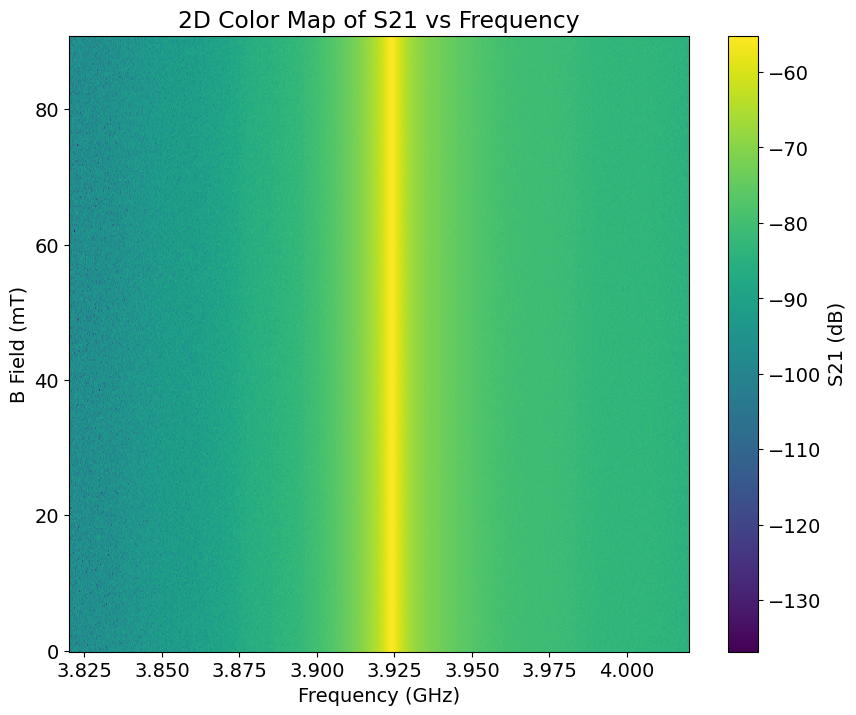

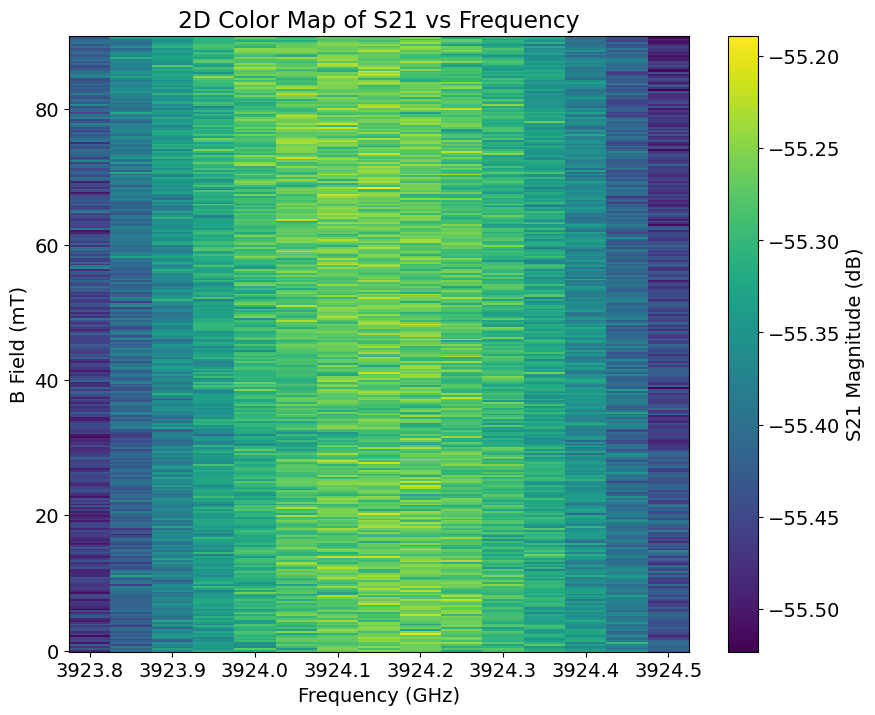

In [49]:

path = "data_vna/data_03_02_2025_magnet_ramp_fine_up/"
data_files =  sorted(glob.glob(path +"*"))

aligned_frequencies = None
s21_magnitudes = []
spectra_times = []
magnetic_fields = []
loaded_q =[]
resonant_freq =[]
s21_max = []
 
# Process each file
for file in data_files:
    data = mf.read_VNA_data_magnets(file)
    time_str = file.split('_')[-1]
    time_str = int(time_str.replace("-", ""))
    spectra_times.append(time_str)

    features = mf.calculate_S21_features(data, [3.86, 4.06], to_print=False)
    features_2 = mf.extract_s21_features( data["Frequency (GHz)"],  data["S21 (dB)"])
    loaded_q.append(features_2.get("Q_tot"))
    resonant_freq.append(features_2.get("f_res"))
    s21_max.append(features_2.get("S21_peak"))

    # loaded_q.append(features.get("Q_loaded"))
    # resonant_freq.append(features.get("f_r"))
    # s21_max.append(features.get("S_21_mag_at_f_r"))

    # Use the first file's frequencies as the reference grid
    if aligned_frequencies is None:
        aligned_frequencies = data["Frequency (GHz)"].values
    
    # Interpolate S21 data onto the reference frequency grid
    interp_s21 = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["S21 (dB)"])
    s21_magnitudes.append(interp_s21)

    # Interpolate S21 data onto the reference frequency grid
    interp_B = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["Magnetic Field (T)"])
    magnetic_fields.append(interp_B)


# Convert to 2D array for plotting
s21_magnitudes = np.array(s21_magnitudes)
magnetic_fields = np.array(magnetic_fields)
resonant_freq = np.array(resonant_freq)
s21_magnitudes = np.array(s21_magnitudes)
loaded_q = np.array(loaded_q)
print(magnetic_fields.shape)
assert np.all(magnetic_fields == magnetic_fields[:, [0]]), "Not all values in each row are identical!"
magnetic_fields = magnetic_fields[:,0]
magnetic_fields = magnetic_fields*1e3
resonant_freq = resonant_freq.squeeze()

print(magnetic_fields.shape)

# Create a 2D color map plot
plt.figure(figsize=(10, 8))
plt.pcolormesh(aligned_frequencies, magnetic_fields, s21_magnitudes, shading='auto', cmap='viridis')
plt.colorbar(label="S21 (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()


lower_bound_freq= 3.9238
upper_bound_freq = 3.9245
zoom_mask = (aligned_frequencies >= lower_bound_freq) & (aligned_frequencies <= upper_bound_freq)
zoomed_frequencies = aligned_frequencies[zoom_mask]
zoomed_s21_magnitudes = s21_magnitudes[:, zoom_mask]
lower_bound_b = 40 
upper_bound_b = 50
zoomed_mask_magentic_fields = (magnetic_fields >= lower_bound_b) & (magnetic_fields <= upper_bound_b)
zoomed_magnetic_fields = magnetic_fields[zoomed_mask_magentic_fields]

plt.figure(figsize=(10, 8))
plt.pcolormesh(zoomed_frequencies*1E3,magnetic_fields, zoomed_s21_magnitudes, shading='auto', cmap='viridis')
#plt.ylim([20,40])
plt.colorbar(label="S21 Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()



In [66]:
plot_spectrum_for_bfield(47,aligned_frequencies,magnetic_fields,s21_magnitudes,margin=5)
print("Min B-field:", np.min(magnetic_fields))
print("Max B-field:", np.max(magnetic_fields))
print("Target range:", target_bfield - margin, "to", target_bfield + margin)
print("Matching B-fields:", magnetic_fields[(magnetic_fields >= target_bfield - margin) & (magnetic_fields <= target_bfield + margin)])


[]
No spectra found within ±5 mT of 47 mT.
Min B-field: -0.008236
Max B-field: 90.85532500000001


NameError: name 'target_bfield' is not defined

In [42]:
print(resonant_freq)

[3.92415341 3.92415158 3.92414979 3.9241502  3.92415319 3.92415074
 3.92415116 3.92415041 3.92415342 3.92415281 3.92415122 3.92415339
 3.92415132 3.9241525  3.92414908 3.92415244 3.92415117 3.92415366
 3.92415073 3.92415138 3.92415232 3.92415055 3.9241521  3.92415195
 3.92414846 3.92415124 3.92415065 3.92415153 3.92415463 3.92415108
 3.92414914 3.92415127 3.92415237 3.92415061 3.92415363 3.92415282
 3.92415035 3.92415218 3.92415206 3.92415184 3.92415267 3.92415093
 3.92415142 3.92415275 3.92414988 3.92415034 3.92414939 3.92414827
 3.92414922 3.92415019 3.92415311 3.92415093 3.92414775 3.9241497
 3.92414966 3.92414847 3.92415208 3.92414956 3.92415183 3.92415001
 3.92415134 3.92414786 3.92414833 3.92414957 3.92414904 3.92414906
 3.924148   3.92414869 3.92415196 3.92414746 3.92414799 3.92414925
 3.92414719 3.92414546 3.92414695 3.92414732 3.92414763 3.92414689
 3.92414742 3.92414561 3.9241463  3.92415056 3.9241478  3.92414836
 3.92414725 3.924147   3.9241476  3.92414525 3.92414622 3.92414

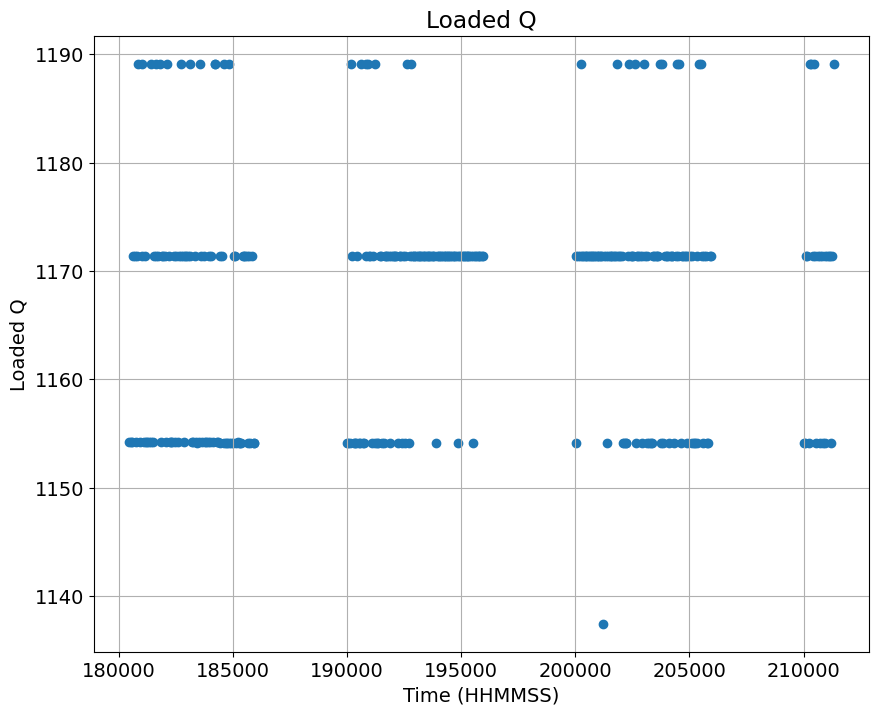

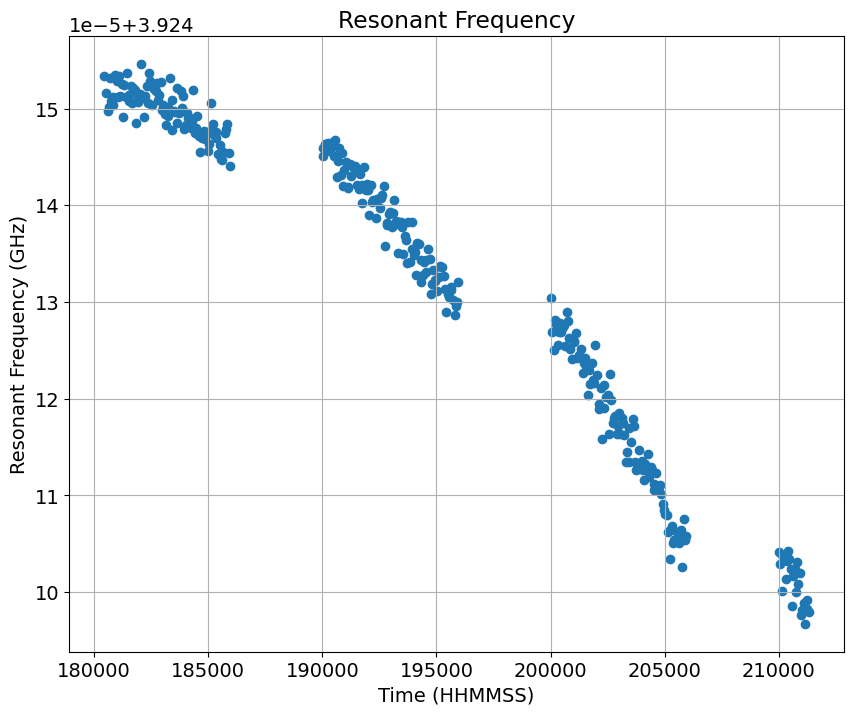

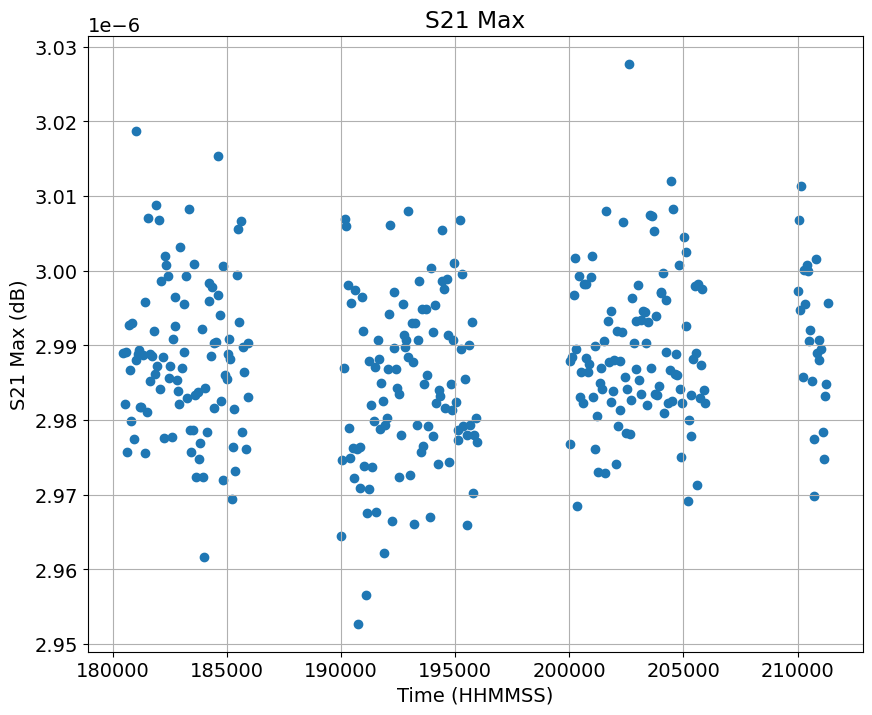

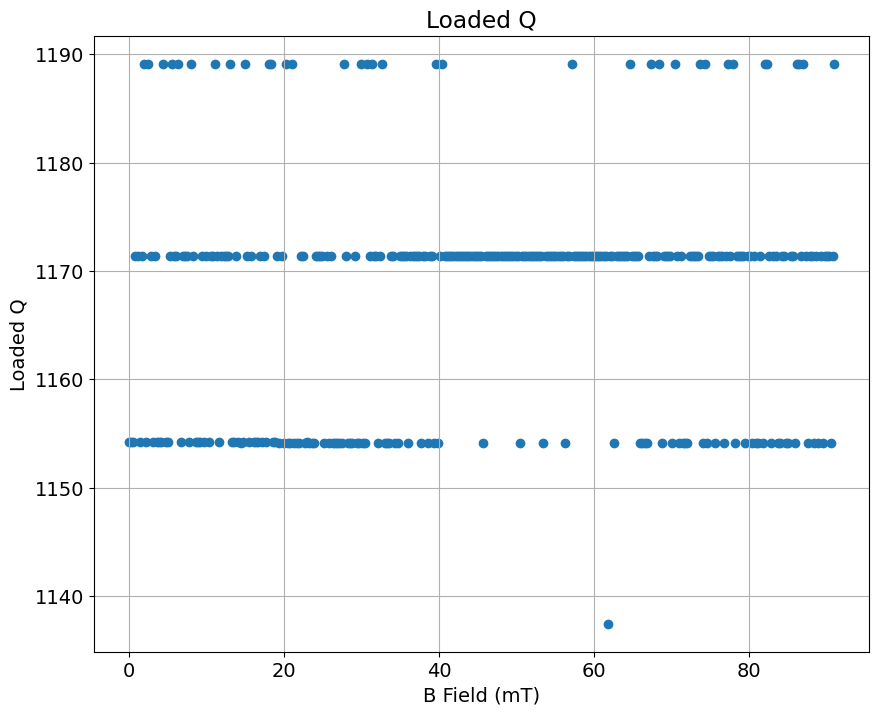

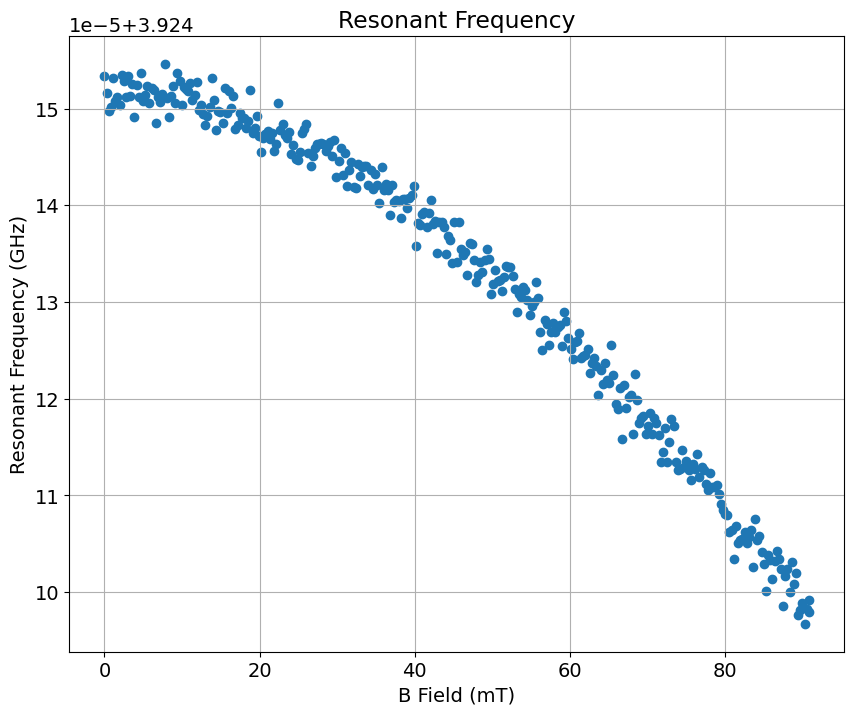

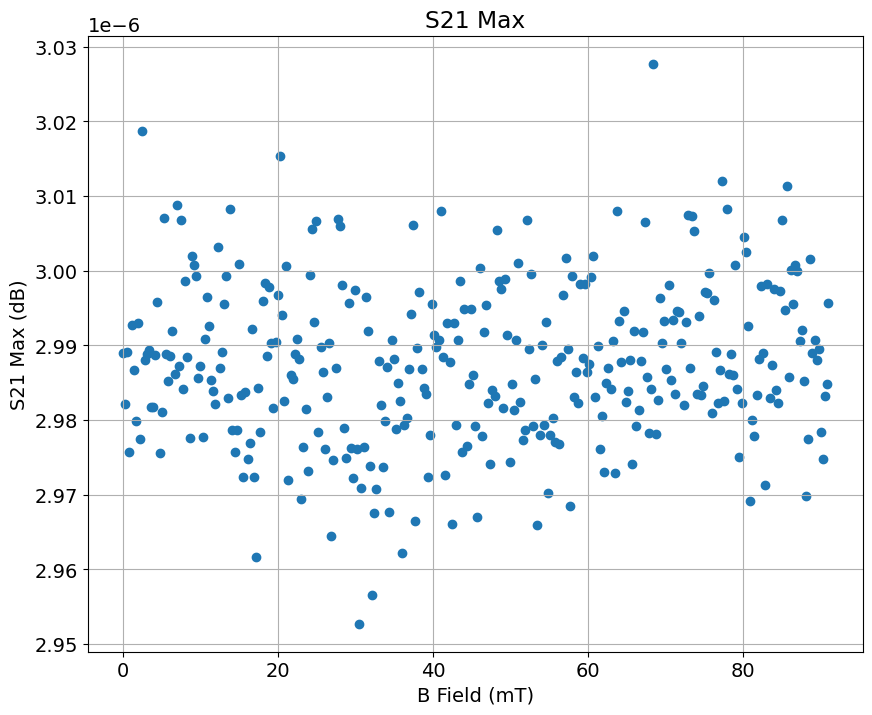

In [41]:
# First Plot: Loaded Q
fig1 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(spectra_times, loaded_q, label="Loaded Q, f1", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(spectra_times, resonant_freq, label="Resonant Frequency", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(spectra_times, s21_max, label="S21 Max", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()

# First Plot: Loaded Q
fig1 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, loaded_q, label="Loaded Q, f1", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, resonant_freq, label="Resonant Frequency", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, s21_max, label="S21 Max", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()

(328, 4001)
(328,)


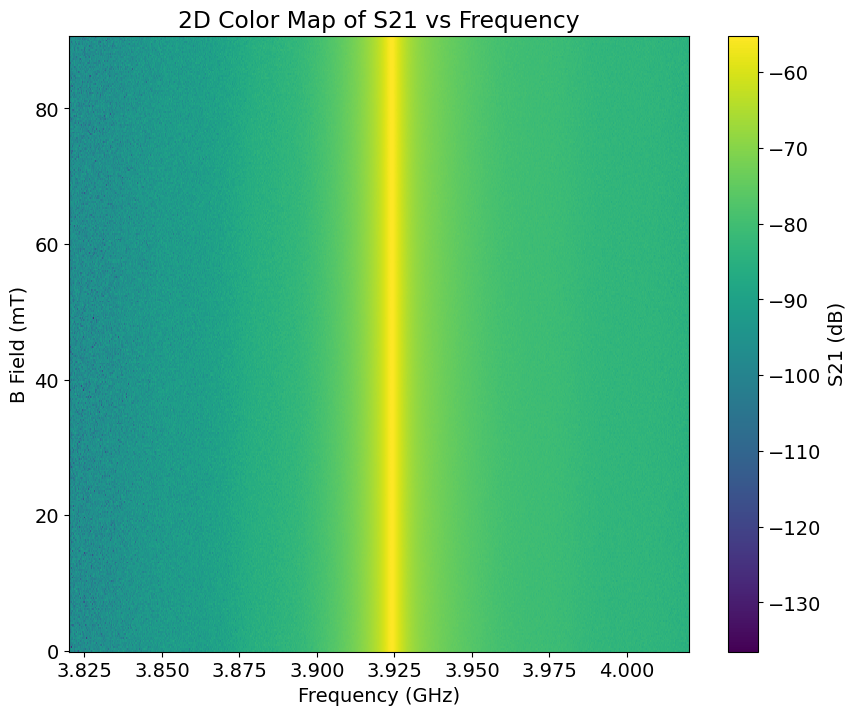

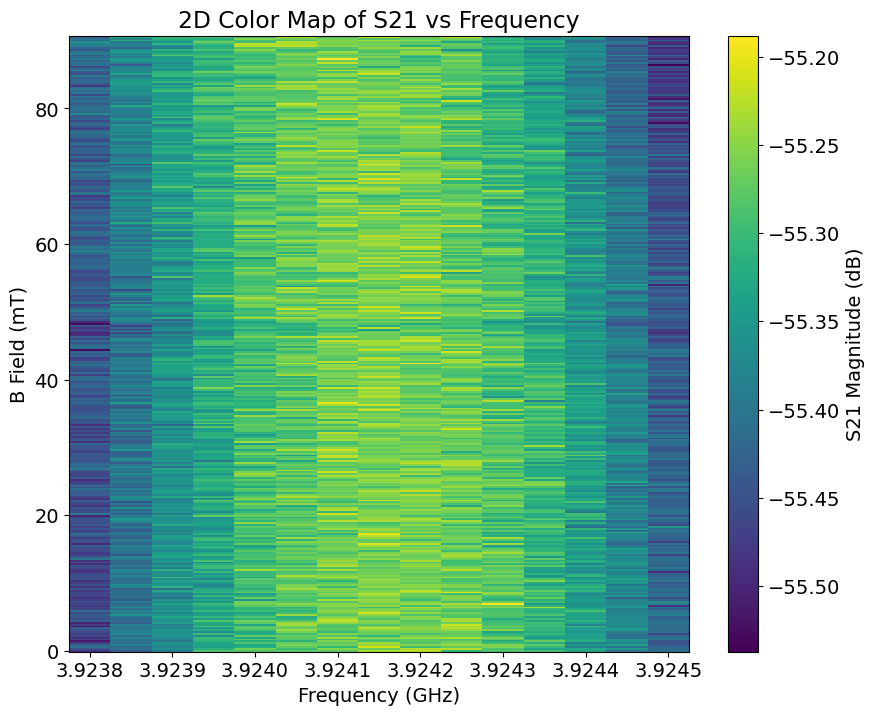

In [91]:

path = "data_vna/data_03_02_2025_magnet_ramp_fine_down/"
data_files =  sorted(glob.glob(path +"*"))

aligned_frequencies = None
s21_magnitudes = []
spectra_times = []
magnetic_fields = []
loaded_q =[]
resonant_freq =[]
s21_max = []
 
# Process each file
for file in data_files:
    data = mf.read_VNA_data_magnets(file)
    time_str = file.split('_')[-1]
    time_str = int(time_str.replace("-", ""))
    spectra_times.append(time_str)

    features = mf.calculate_S21_features(data, [3.86, 4.06], to_print=False)
    features = mf.calculate_S21_features(data, [3.86, 4.06], to_print=False)
    features_2 = mf.extract_s21_features( data["Frequency (GHz)"],  data["S21 (dB)"])
    loaded_q.append(features_2.get("Q_tot"))
    resonant_freq.append(features_2.get("f_res"))
    s21_max.append(features_2.get("S21_peak"))

    # Use the first file's frequencies as the reference grid
    if aligned_frequencies is None:
        aligned_frequencies = data["Frequency (GHz)"].values
    
    # Interpolate S21 data onto the reference frequency grid
    interp_s21 = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["S21 (dB)"])
    s21_magnitudes.append(interp_s21)

    # Interpolate S21 data onto the reference frequency grid
    interp_B = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["Magnetic Field (T)"])
    magnetic_fields.append(interp_B)


# Convert to 2D array for plotting
s21_magnitudes = np.array(s21_magnitudes)
magnetic_fields = np.array(magnetic_fields)
resonant_freq = np.array(resonant_freq)
s21_magnitudes = np.array(s21_magnitudes)
loaded_q = np.array(loaded_q)
print(magnetic_fields.shape)
assert np.all(magnetic_fields == magnetic_fields[:, [0]]), "Not all values in each row are identical!"
magnetic_fields = magnetic_fields[:,0]
magnetic_fields = magnetic_fields*1e3
resonant_freq = resonant_freq.squeeze()

print(magnetic_fields.shape)

# Create a 2D color map plot
plt.figure(figsize=(10, 8))
plt.pcolormesh(aligned_frequencies, magnetic_fields, s21_magnitudes, shading='auto', cmap='viridis')
plt.colorbar(label="S21 (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()


lower_bound_freq= 3.9238
upper_bound_freq = 3.9245
zoom_mask = (aligned_frequencies >= lower_bound_freq) & (aligned_frequencies <= upper_bound_freq)
zoomed_frequencies = aligned_frequencies[zoom_mask]
zoomed_s21_magnitudes = s21_magnitudes[:, zoom_mask]
#zoomed_magnetic_fields = magnetic_fields[:, zoom_mask]

plt.figure(figsize=(10, 8))
plt.pcolormesh(zoomed_frequencies, magnetic_fields, zoomed_s21_magnitudes, shading='auto', cmap='viridis')
plt.colorbar(label="S21 Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
#plt.ylim([40,60])
plt.title("2D Color Map of S21 vs Frequency")
plt.show()



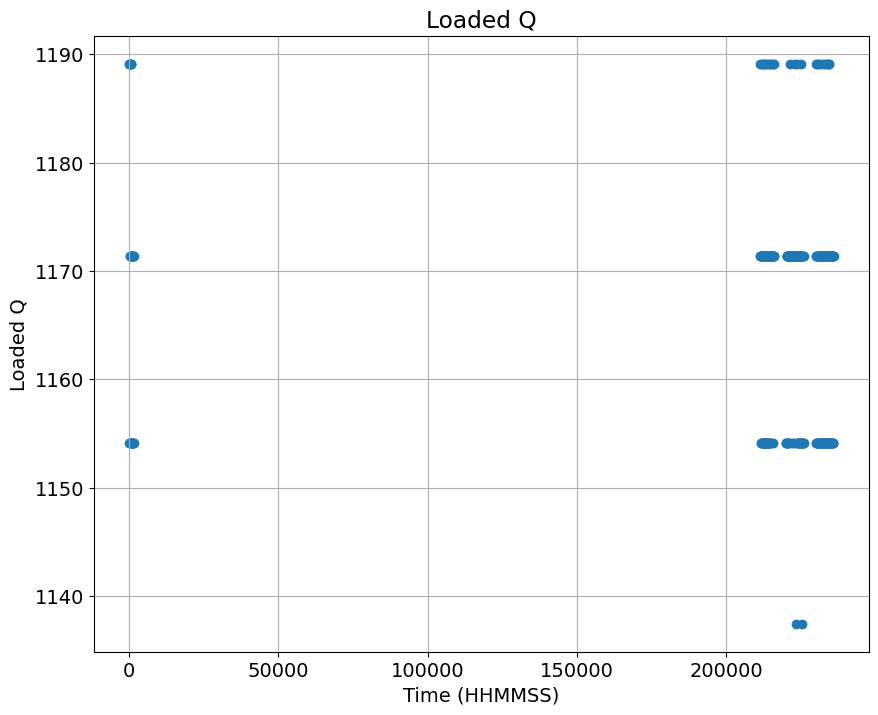

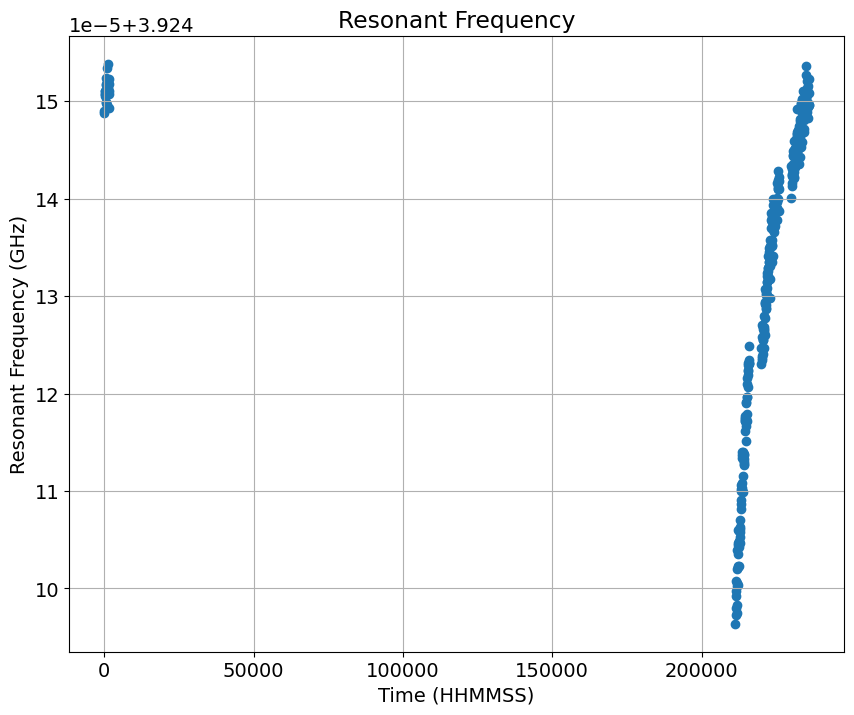

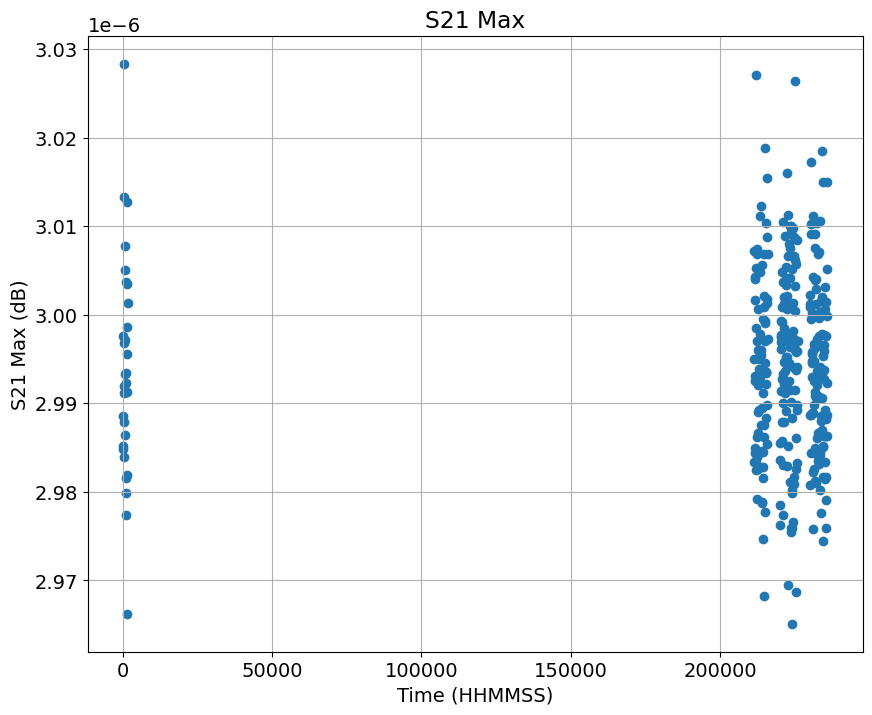

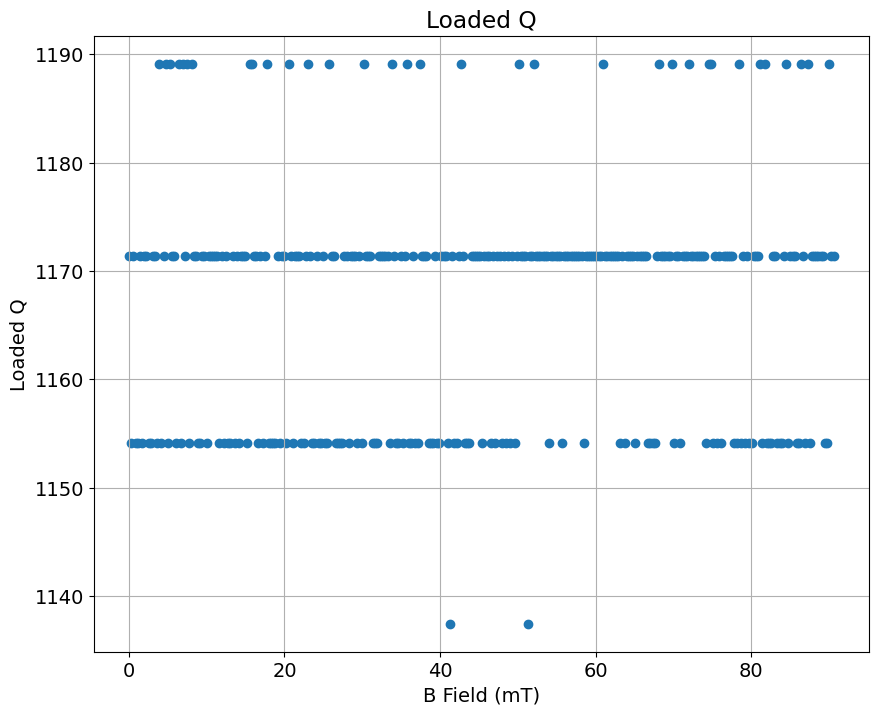

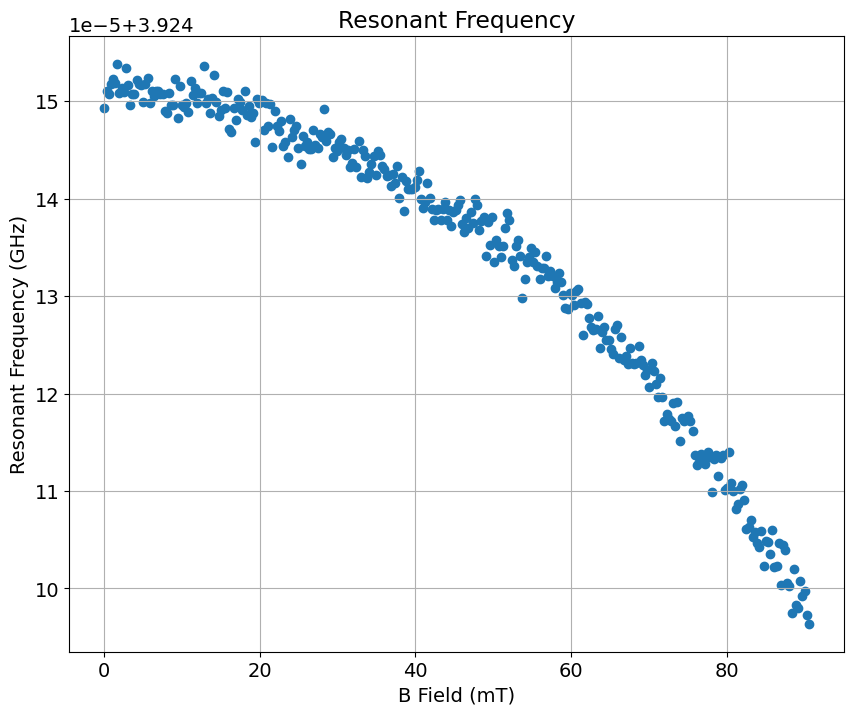

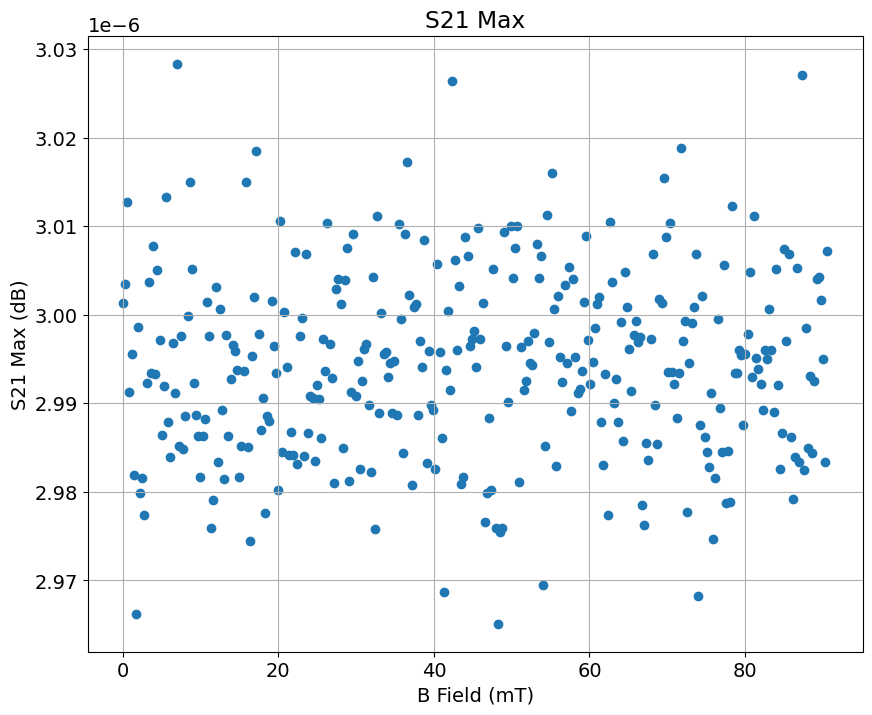

In [46]:
# First Plot: Loaded Q
fig1 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(spectra_times, loaded_q, label="Loaded Q, f1", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(spectra_times, resonant_freq, label="Resonant Frequency", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(spectra_times, s21_max, label="S21 Max", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()

# First Plot: Loaded Q
fig1 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, loaded_q, label="Loaded Q, f1", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, resonant_freq, label="Resonant Frequency", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, s21_max, label="S21 Max", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()